<a href="https://colab.research.google.com/github/infyprakash/Intrusion-detection-system/blob/main/IDS_using_conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","score"]

In [ ]:
train_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Intrusion detection system/NSL-KDD/KDDTrain+.txt',
    names=col_names,header=None
    )
test_df = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/Intrusion detection system/NSL-KDD/KDDTest+.txt',
    names=col_names,header=None
)

In [ ]:
def assign_category(attack):
  normal = ['normal']
  dos = ['neptune','teardrop','smurf','pod','back','land',]
  probe = ['ipsweep','portsweep','nmap','satan',]
  u2r = ['rootkit','buffer_overflow','loadmodule','perl']
  r2l = ['warezclient','guess_passwd','ftp_write','multihop','imap','warezmaster','phf','spy']
  if attack in dos:
    return "dos"
  elif attack in normal:
    return 'normal'
  elif attack in probe:
    return "probe"
  elif attack in u2r:
    return "u2r"
  else:
    return "r2l"

In [ ]:
train_df['label'] = train_df['label'].apply(assign_category)
test_df['label'] = test_df['label'].apply(assign_category)

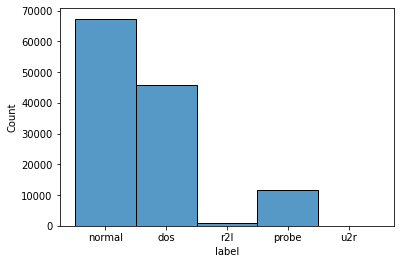

In [ ]:
sns.histplot(data=train_df,x='label')
plt.show()

In [ ]:
categorical_columns = []
for col in train_df.columns:
  if(train_df[col].dtypes=='O'):
    categorical_columns.append(col)

In [ ]:
categorical_columns.pop()

'label'

In [ ]:
for col in categorical_columns:
  train_df = pd.get_dummies(train_df, columns=[col], prefix=col, prefix_sep='_')
  test_df = pd.get_dummies(test_df, columns=[col], prefix=col, prefix_sep='_')

In [ ]:
train_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,score,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,dos,19,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
test_df.head(2)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,score,...,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.0,1.0,1.0,0.04,0.06,0.0,255,10,0.04,0.06,0.0,0.0,0.0,0.0,1.0,1.0,dos,21,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.0,0.0,0.0,0.0,1.0,1.0,dos,21,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
train_cols = train_df.columns
test_cols = test_df.columns

In [ ]:
col_diff = []
for col in train_cols:
  if col not in test_cols:
    col_diff.append(col)

In [ ]:
train_df = train_df.drop(columns=col_diff)

In [ ]:
train_features = train_df.copy()
test_features = test_df.copy()

In [ ]:
train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

train_features = np.array(train_features).reshape(125973, 117,1)

In [ ]:
normalizer = layers.Normalization(axis=-1)

In [ ]:
normalizer.adapt(np.array(train_features))

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
train_labels = le.fit_transform(train_labels)

In [ ]:
test_labels = le.transform(test_labels)

In [ ]:
from tensorflow.keras import models
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

In [ ]:
model = models.Sequential()

In [ ]:
# model.add(normalizer)
model.add(tf.keras.layers.Conv1D(64, 1, activation='relu',input_shape=(117,1)))
model.add(Dense(16, activation="relu"))
model.add(MaxPooling1D())
# model.add(Flatten())
model.add(Flatten())
model.add(Dense(5, activation = 'softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 117, 64)           128       
                                                                 
 dense (Dense)               (None, 117, 16)           1040      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 58, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 928)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 4645      
                                                                 
Total params: 5,813
Trainable params: 5,813
Non-trainable params: 0
______________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = model.fit(train_features,train_labels,validation_split=0.2,epochs=10,batch_size=1, callbacks=[callback],verbose=1)


Epoch 1/10
100778/100778 [==============================] - 427s 4ms/step - loss: 0.9082 - accuracy: 0.9640 - val_loss: 0.0476 - val_accuracy: 0.9852
Epoch 2/10
100778/100778 [==============================] - 416s 4ms/step - loss: 0.0390 - accuracy: 0.9905 - val_loss: 0.0298 - val_accuracy: 0.9931
Epoch 3/10
100778/100778 [==============================] - 363s 4ms/step - loss: 0.0364 - accuracy: 0.9922 - val_loss: 0.0275 - val_accuracy: 0.9930
Epoch 4/10
100778/100778 [==============================] - 360s 4ms/step - loss: 0.9737 - accuracy: 0.9926 - val_loss: 0.0314 - val_accuracy: 0.9929
Epoch 5/10
100778/100778 [==============================] - 358s 4ms/step - loss: 0.1937 - accuracy: 0.9929 - val_loss: 0.0241 - val_accuracy: 0.9949
Epoch 6/10
100778/100778 [==============================] - 375s 4ms/step - loss: 0.0310 - accuracy: 0.9934 - val_loss: 0.0243 - val_accuracy: 0.9946
Epoch 7/10
100778/100778 [==============================] - 383s 4ms/step - loss: 0.0367 - accuracy:

In [ ]:
!mkdir -p saved_model
model.save('saved_model_2/conv1d_model')

INFO:tensorflow:Assets written to: saved_model_2/conv1d_model/assets


In [ ]:

test_loss, test_acc  = model.evaluate(test_features,test_labels, verbose=2)

705/705 - 5s - loss: 4.0005 - accuracy: 0.7252 - 5s/epoch - 7ms/step


In [ ]:
print(test_acc)

0.725248396396637


In [ ]:
test_features = np.array(test_features).reshape(22544, 117,1)

In [ ]:

test_loss, test_acc  = model.evaluate(test_features,test_labels, verbose=2)

705/705 - 4s - loss: 4.0005 - accuracy: 0.7252 - 4s/epoch - 6ms/step


In [ ]:
new_model = tf.keras.models.load_model('saved_model_2/conv1d_model')

In [ ]:
test_loss, test_acc  = model.evaluate(test_features,test_labels, verbose=2)

705/705 - 4s - loss: 4.0005 - accuracy: 0.7252 - 4s/epoch - 5ms/step
